# Chapter 7. Understanding Support Vector Machines

A **Support Vector Machine (SVM)** can be imagined as a surface that creates a boundary between points of data plotted in multidimensional space. The goal of a SVM is to create a flat boundary called a **hyperplane**, which divides the space to create fairly homogeneous partitions on either side.

SVMs can be adapted for use with nearly any type of learning task, including both classification and numeric prediction. Many of the algorithm's key successes have come in pattern recognition. Notable applications include:

- Classification of microarray gene expression data in the field of bioinformatics to identify cancer or other genetic diseases
- Text categorization such as identification of the language used in a document or the classification of documents by subject matter
- The detection of rare yet important events like combustion engine failure, security breaches, or earthquakes

### Classification with hyperplanes

As noted previously, SVMs use a boundary called a hyperplane to partition data into groups of similar class values. In two dimensions, the task of the SVM algorithm is to identify a line that separates the two classes. As shown in the following figure, there is more than one choice of dividing line between the groups of two groups. Three such possibilities are shown. How does the algorithm choose?

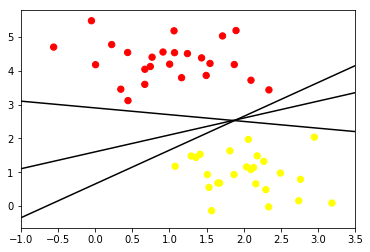

In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.datasets.samples_generator import make_blobs
# make_blob used to generate Gaussian blobs for clustering
# center is group numbers, cluster_std define how close the dots to the center.
# X is the pair of x and y axis, y is the membership
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap='autumn')
# '-k' used to remove colour of the lines
for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

**Maximum Margin Hyperplane (MMH)** that creates the greatest separation between the two classes will do the job. Although any of the three lines separating the two group would correctly classify all the data points, it is likely that the line that leads to the greatest separation will generalize the best to the future data. The intuition is this: rather than simply drawing a zero-width line between the classes, we can draw around each line a margin of some width, up to the nearest point. Here is an example of how this might look:

(-1, 3.5)

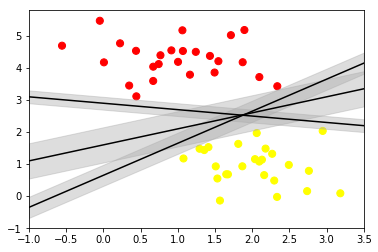

In [2]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

In support vector machines, the line that maximizes this margin is the one we will choose as the optimal model. The middle line is the one. Support vector machines are an example of such a maximum margin estimator.

### Fitting a support vector machine

The **support vectors**  are the points from each class that are the closest to the MMH; each class must have at least one support vector, but it is possible to have more than one. we will use Scikit-Learn's support vector classifier to train an SVM model on this data. For the time being, we will use a linear kernel and set the C parameter to a very large number.

In [3]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

let's create a quick convenience function that will plot SVM decision boundaries

In [4]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

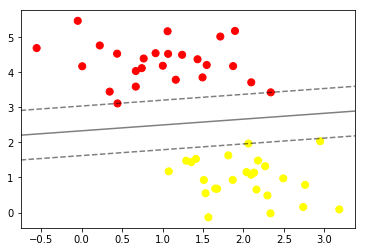

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that maximizes the margin between the two sets of points. Notice that a few of the training points just touch the margin: These points are the pivotal elements of this fit, and are known as the **support vectors**.In Scikit-Learn, the identity of these points are stored in the *support_vectors_* attribute of the classifier:

In [6]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

### Linearly Separable Data 

It is easiest to understand how to find the maximum margin under the assumption that the classes are linearly separable. In this case, the MMH is as far away as possible from the outer boundaries of the two groups of data points. These outer boundaries are known as the **convex hull**. The MMH is then the perpendicular bisector of the shortest line between the two convex hulls. Sophisticated computer algorithms that use a technique known as **quadratic optimization** are capable of finding the maximum margin in this way.

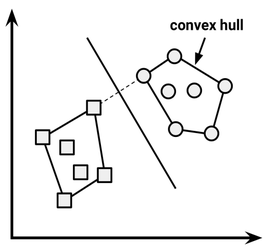

In [10]:
from PIL import Image 
myImage = Image.open("/Users/jiaoyu/Documents/Ph.D/teaching/Machine_learning_with_R/ch7_SVM/svm3.jpg")
myImage3 = myImage.resize((270, 250), Image.ANTIALIAS)
display(myImage3)

To use a metaphor, one can imagine this process as similar to trying to find the thickest mattress that can fit up a stairwell to your bedroom.

To understand this search process, we'll need to define exactly what we mean by a hyperplane. In n-dimensional space

$\vec w * \vec x + b = 0$

$w$ is a vector of n weights, that is, $(w_{1}, w_{2}, ..., w_{n})$, and $b$ is a single number known as the bias. The bias is conceptually equivalent to the intercept term in the slope-intercept form. Simply think of the equation as a way to specify a surface, much like when the slope-intercept form $(y = mx + b)$ is used to specify lines in 2D space

Using this formula, the goal of the process is to find a set of weights that specify two hyperplanes, as follows:

$\vec w * \vec x + b \ge +1$

$\vec w * \vec x + b \le -1$

We will also require that these hyperplanes are specified such that all the points of one class fall above the first hyperplane and all the points of the other class fall beneath the second hyperplane. This is possible so long as the data are linearly separable.

Vector geometry defines the distance between these two planes as:

$min \frac{1}{2}||\vec w||^{2}$

$s.t. y_{i}(\vec w * \vec x_{i} - b) \ge 1$, for  all $\vec x_{i}$ 

The first line implies that we need to minimize the **Euclidean norm** (squared and divided by two to make the calculation easier). The second line notes that this is subject to (s.t.), the condition that each of the $y_{i}$ data points is correctly classified. Note that $y$ indicates the class value (transformed to either +1 or -1) 

As with the other method for finding the maximum margin, finding a solution to this problem is a task best left for quadratic optimization software. Although it can be processor-intensive, specialized algorithms are capable of solving these problems quickly even on fairly large datasets.

### Non Linearly Separable Data 

What if the data are not linearly separable? The solution to this problem is the use of a slack variable, which creates a soft margin that allows some points to fall on the incorrect side of the margin. The figure that follows illustrates two points falling on the wrong side of the line with the corresponding slack terms (denoted with the Greek letter $Xi$):

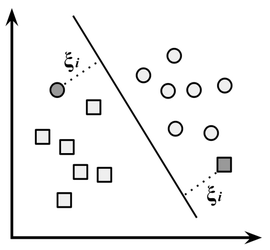

In [30]:
myImage = Image.open("/Users/jiaoyu/Documents/Ph.D/teaching/Machine_learning_with_R/ch7_SVM/svm4.jpg")
myImage4 = myImage.resize((270, 250), Image.ANTIALIAS)
display(myImage4)

A cost value (denoted as C) is applied to all points that violate the constraints, and rather than finding the maximum margin, the algorithm attempts to minimize the total cost. We can therefore revise the optimization problem to

$min \frac{1}{2}||\vec w||^{2} + C \sum_{i=1}^{n} \xi_{i} $

$s.t. y_{i}(\vec w * \vec x_{i} - b) \ge 1-\xi_{i}$, for  all $\vec x_{i}, \xi_{i}>0$ 

The important piece to understand is the addition of the cost parameter $C$. Modifying this value will adjust the penalty, for example, the fall on the wrong side of the hyperplane. The greater the cost parameter, the harder the optimization will try to achieve 100 percent separation. On the other hand, a lower cost parameter will place the emphasis on a wider overall margin. It is important to strike a balance between these two in order to create a model that generalizes well to future data.

#### Softening Margins

If the data has some amount of overlap? For example, you may have data like this:

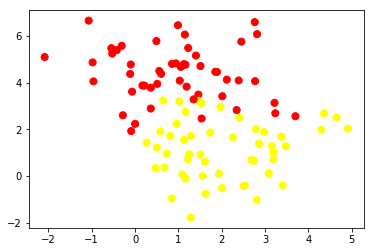

In [34]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points. The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation, etc.

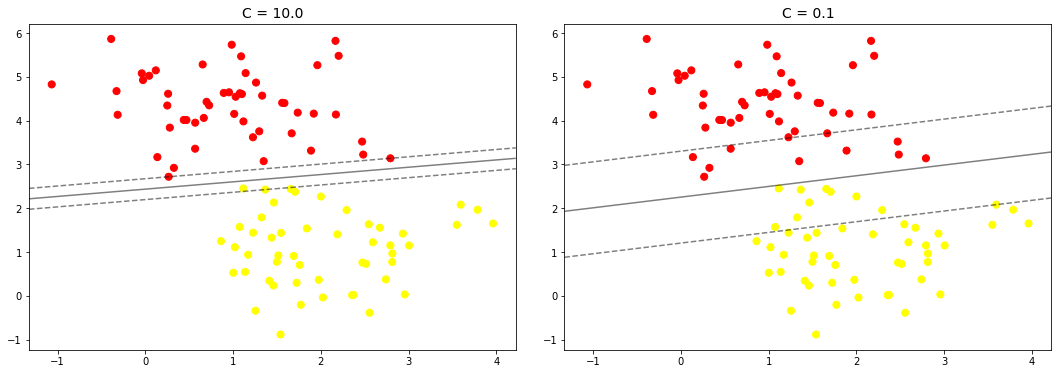

In [35]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

### Using kernels for non-linear spaces

A key feature of SVMs is their ability to map the problem into a higher dimension space using a process known as the **kernel trick**. In doing so, a nonlinear relationship may suddenly appear to be quite linear.

Though this seems like nonsense, it is actually quite easy to illustrate by example. In the following figure, the scatterplot on the left depicts a nonlinear relationship between a weather class (sunny or snowy) and two features: latitude and longitude. The points at the center of the plot are members of the snowy class, while the points at the margins are all sunny. Such data could have been generated from a set of weather reports, some of which were obtained from stations near the top of a mountain, while others were obtained from stations around the base of the mountain.

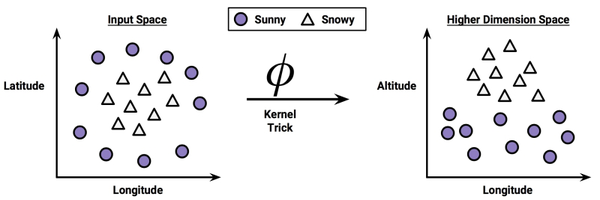

In [31]:
myImage = Image.open("/Users/jiaoyu/Documents/Ph.D/teaching/Machine_learning_with_R/ch7_SVM/svm5.jpg")
myImage5 = myImage.resize((600, 200), Image.ANTIALIAS)
display(myImage5)

On the right side of the figure, after the kernel trick has been applied, we look at the data through the lens of a new dimension: altitude. With the addition of this feature, the classes are now perfectly linearly separable. This is possible because we have obtained a new perspective on the data. In the left figure, we are viewing the mountain from a bird's eye view, while in the right one, we are viewing the mountain from a distance at the ground level. Here, the trend is obvious: snowy weather is found at higher altitudes.

SVMs with nonlinear kernels add additional dimensions to the data in order to create separation in this way. Essentially, the kernel trick involves a process of constructing new features that express mathematical relationships between measured characteristics. SVMs with nonlinear kernels are extremely powerful classifiers, although they do have some downsides

- Strengths
- Can be used for classification or numeric prediction problems
- Not overly influenced by noisy data and not very prone to overfitting
- May be easier to use than neural networks, particularly due to the existence of several well-supported SVM algorithms
- Gaining popularity due to its high accuracy and high-profile wins in data mining competitions

- Weakness
- Finding the best model requires testing of various combinations of kernels and model parameters
- Can be slow to train, particularly if the input dataset has a large number of features or examples
- Results in a complex black box model that is difficult, if not impossible, to interpret

Kernel functions, in general, are of the following form. The function denoted by the Greek letter phi, that is, $\phi (x)$, is a mapping of the data into another space. The general kernel function applies some transformation to the feature vectors $x_{i}$ and $x_{j}$ and combines them using the dot product, which takes two vectors and returns a single number.

$K(\vec x_{i} , \vec x_{j}) =\phi (\vec x_{i}) \cdot \phi (\vec x_{j})$

The **linear kernel** does not transform the data at all. Therefore, it can be expressed simply as the dot product of the features:

$K(\vec x_{i} , \vec x_{j}) =\vec x_{i} \cdot \vec x_{j}$

The **polynomial kernel** of degree $d$ adds a simple nonlinear transformation of the data:

$K(\vec x_{i} , \vec x_{j}) =(\vec x_{i} \cdot \vec x_{j}+1)^{d}$

The **sigmoid kernel** results in a SVM model somewhat analogous to a neural network using a sigmoid activation function.

$K(\vec x_{i} , \vec x_{j}) =tanh(\kappa \vec x_{i} \cdot \vec x_{j}- \delta)$

The **Gaussian RBF kernel** is similar to a RBF neural network. The RBF kernel performs well on many types of data and is thought to be a reasonable starting point for many learning tasks:

$K(\vec x_{i} , \vec x_{j}) =e^{\frac{-||\vec x_{i}-\vec x_{j}||^{2}}{2 \sigma^{2}}}$

There is no reliable rule to match a kernel to a particular learning task. The fit depends heavily on the concept to be learned as well as the amount of training data and the relationships among the features. Often, a bit of trial and error is required by training and evaluating several SVMs on a validation dataset. This said, in many cases, the choice of kernel is arbitrary, as the performance may vary slightly. 

### A nonlinear example

Let us use the previous example, If the distribution of data is as following:

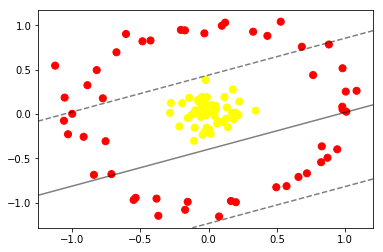

In [11]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False)

It is clear that no linear discrimination will ever be able to separate this data. How we might project the data into a higher dimension such that a linear separator would be sufficient. Another way is to use a kernel trick. In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [32]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

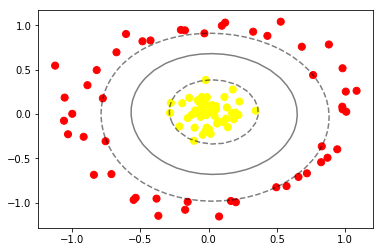

In [33]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. 

#### Example: using SVM to identify Mnist handwritten digits data 

In [26]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC


In [29]:
import pandas as pd
data=pd.read_csv("/Users/jiaoyu/Documents/Ph.D/teaching/Machine_learning_with_R/ch3_KNN/training.csv")

In [30]:
x=data.iloc[:,1:(data.shape[1])].values
y=data.iloc[:,0].values
print(x.shape)
print(y.shape)

(21000, 784)
(21000,)


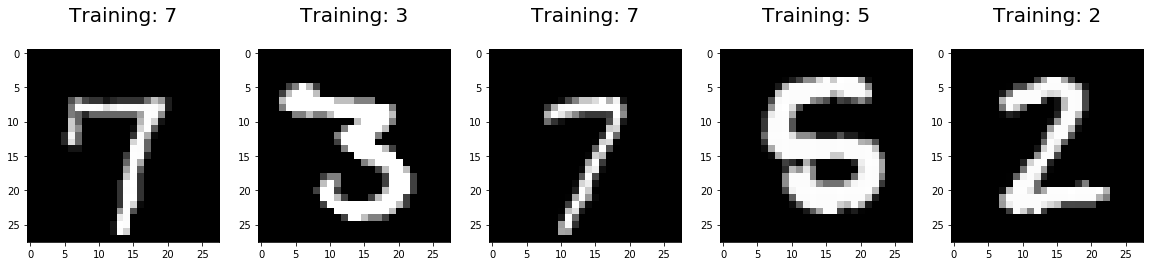

In [51]:
plt.figure(figsize=(20,4))
for index, (image, label) in enumerate(zip(x[1:6], y[1:6])):
    plt.subplot(1,5, index+1)
    plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20,random_state=12)

In [32]:
## normalize the data 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [52]:
print(X_train.shape)
print(y_train.shape)

(16800, 784)
(16800,)


Let a Gaussian RBF kernel and a linear kernel to perform SVM

In [53]:
from sklearn import svm
clf = svm.SVC(kernel='rbf', C=20,gamma=0.001)

In [54]:
clf.fit(X_train, y_train)

SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [55]:
y_pred = clf.predict(X_test)

In [56]:
from sklearn import metrics

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test,y_pred)) 

Accuracy: 0.9597619047619048
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       394
           1       0.98      0.98      0.98       455
           2       0.91      0.95      0.93       429
           3       0.96      0.95      0.96       440
           4       0.95      0.94      0.95       378
           5       0.96      0.95      0.95       399
           6       0.98      0.96      0.97       423
           7       0.96      0.97      0.97       416
           8       0.96      0.95      0.96       435
           9       0.97      0.95      0.96       431

   micro avg       0.96      0.96      0.96      4200
   macro avg       0.96      0.96      0.96      4200
weighted avg       0.96      0.96      0.96      4200



In [41]:
svmlinear = svm.SVC(kernel='linear')
svmlinear.fit(X_train, y_train)
y_pred = svmlinear.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9138095238095238


In [42]:
print(classification_report(y_test,y_pred)) 

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       394
           1       0.94      0.98      0.96       455
           2       0.89      0.90      0.89       429
           3       0.86      0.92      0.89       440
           4       0.88      0.92      0.90       378
           5       0.88      0.87      0.88       399
           6       0.97      0.95      0.96       423
           7       0.94      0.93      0.93       416
           8       0.93      0.84      0.88       435
           9       0.90      0.87      0.89       431

   micro avg       0.91      0.91      0.91      4200
   macro avg       0.91      0.91      0.91      4200
weighted avg       0.91      0.91      0.91      4200



Gaussian RBF kernel has better performance then linear kernal.